# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, make_scorer

from scipy.stats import spearmanr

import shap

from visualization import plot_predicted_vs_true, plot_loss

import random

2025-04-25 10:31:38.130299: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
np.set_printoptions(suppress=True)

randomize = False
rs = 420 if not randomize else random.randint()
rs

420

# Data Preparation

In [3]:
# Import the data

data = pd.read_csv("data/stress_factors.csv")


In [6]:
# Create factorized version
# One-hot encode the categorical columns
data_encoded = pd.get_dummies(data, drop_first=True)

# Standardize the data (important for PCA)
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_encoded), columns=data.columns)

In [7]:
# Organize column names
predictors = ["Sleep_Quality","Weekly_Headaches","Academic_Performance","Study_Load","Weekly_Extracurriculars"]
targets = ["Stress_Level"]

# Get X and y
X, y = (data_scaled[predictors], data_scaled[targets])

In [8]:
# Assert that there are no NAs
assert(data.isna().sum().sum() == 0)

# Data Summary Statistics

In [9]:
# Basic summary
summary = data_scaled.describe()

# Add MADs
sum_columns = summary.columns
mads = [np.median(np.abs(data_scaled[column] - data_scaled[column].median())) for column in sum_columns]

summary.loc['mad'] = mads

# Formatting
summary = round(summary, 3)


In [10]:
# Display summary
summary

,Sleep_Quality,Weekly_Headaches,Academic_Performance,Study_Load,Weekly_Extracurriculars,Stress_Level
count,520.000,520.000,520.000,520.000,520.000,520.000
mean,0.000,0.000,-0.000,0.000,0.000,0.000
std,1.001,1.001,1.001,1.001,1.001,1.001
min,-1.935,-0.949,-2.195,-1.276,-1.145,-1.382
25%,-1.025,-0.949,-0.308,-0.547,-1.145,-0.645
50%,-0.114,-0.147,-0.308,-0.182,0.216,0.092
75%,0.797,0.656,0.635,0.912,0.897,0.829
max,1.708,2.261,1.578,1.641,1.577,1.567
mad,0.911,0.802,0.943,1.094,0.681,0.737


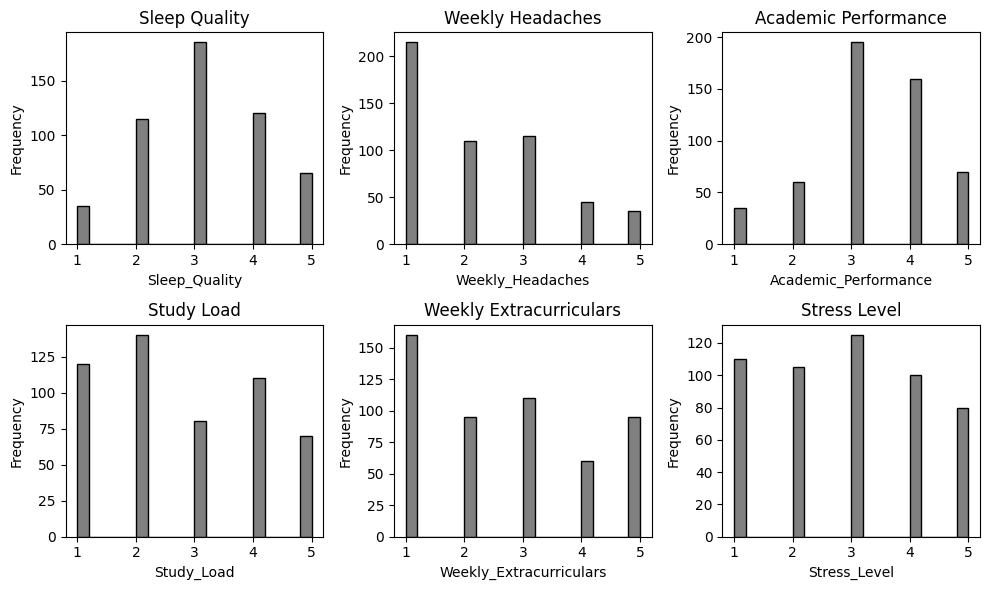

In [11]:
# Set number of columns in the grid
data_to_plot = data
n_cols = 3
n_rows = int(np.ceil(len(data_to_plot.columns) / n_cols))

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 3 * n_rows))
axes = axes.flatten()  # Flatten in case it's 2D

# Plot histograms
for i, col in enumerate(data_to_plot.columns):
    axes[i].hist(data_to_plot[col], bins=20, color='grey', edgecolor='black')
    axes[i].set_title(f'{col.replace("_", " ")}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Factor Analysis

## Factor Analysis Pre-Work

### Spearman Correlation

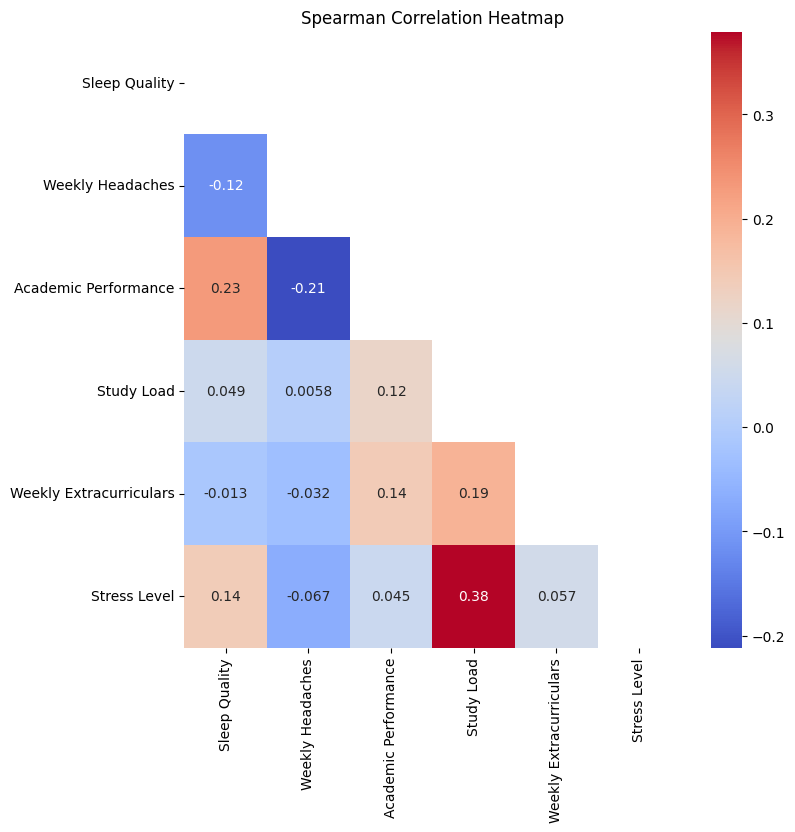

In [12]:
# Compute Spearman correlation matrix
corr, _ = spearmanr(data_scaled)

corr_subset = corr[:6, :6]
labels = list(map(lambda x: x.replace("_", " "), data_encoded.columns))
labels_subset = labels[:6]
mask = np.triu(np.ones_like(corr_subset, dtype = bool))

# Create a heatmap
# labels = list(map(lambda x: x.replace("_", " "), data_encoded.columns))
plt.figure(figsize=(8, 8))
sns.heatmap(corr_subset, mask = mask, annot=True, xticklabels=labels_subset, yticklabels=labels_subset, cmap="coolwarm")
plt.title('Spearman Correlation Heatmap')
plt.show()

### Pearson Correlation

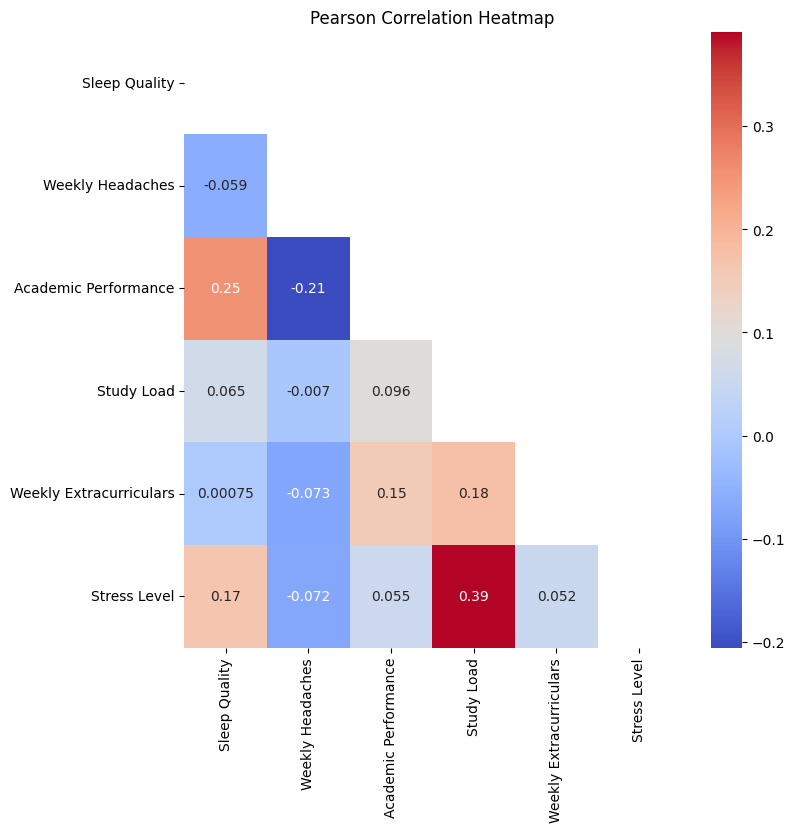

In [13]:
# Compute Pearson correlation matrix
corr = data_scaled.corr(method='pearson')

corr_subset = corr.iloc[:6, :6]
labels = list(map(lambda x: x.replace("_", " "), data_encoded.columns))
labels_subset = labels[:6]
mask = np.triu(np.ones_like(corr_subset, dtype = bool))

# Create a heatmap
# labels = list(map(lambda x: x.replace("_", " "), data_encoded.columns))
plt.figure(figsize=(8, 8))
sns.heatmap(corr_subset, mask = mask, annot=True, xticklabels=labels_subset, yticklabels=labels_subset, cmap="coolwarm")
plt.title('Pearson Correlation Heatmap')
plt.show()

### Scree Plot

In [14]:
# Mean center, covariance matrix
cov_matrix = np.cov(corr_subset, rowvar=False)

# Eigen-values and -vectors, sorted
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

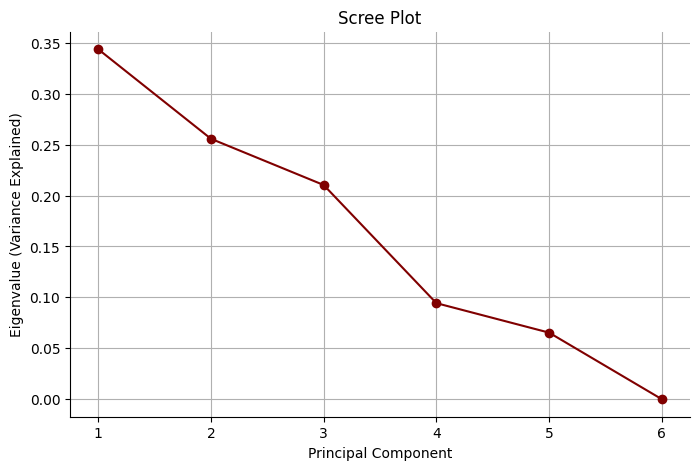

In [15]:
# Scree plot
f, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(range(1, len(sorted_eigenvalues) + 1), sorted_eigenvalues, marker='o', linestyle='-', color="maroon")
ax.set_xlabel('Principal Component')
ax.set_ylabel('Eigenvalue (Variance Explained)')
ax.set_title('Scree Plot')
ax.grid(True)
sns.despine(ax=ax)

We have decided against pursuing latent variable models further; the above scree plot indicates that our data is effectively irreducible.

# Clustering Analysis

Here, we do a short clustering analysis on X. 
We exclude the stress measure as we plan to use the clustering models' output as input to the regression models we'll fit later.

First, we fit clustering models in a loop over k (where k is the number of clusters) to determine the idea k.
We then record the labels for our chosen models as a part of the data to feed into the regressors.

## Determining K

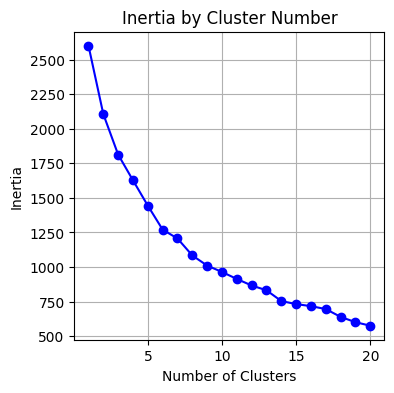

In [21]:
inertias = []
cluster_models = []
k_values = range(1, 21)

# Do a clustering fit for k in the range [1,20]
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=rs)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
    cluster_models.append(kmeans)

# Plot the inertias; the ideal number of clusters should be at the elbow
plt.figure(figsize=(4,4))
plt.plot(k_values, inertias, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Inertia by Cluster Number')
plt.grid(True)
plt.show()

## Incorporating cluster labels

We've chosen to use k-means clustering models with both k=3 and k=8 as the two notable elbow-like points in the above graph.

In [22]:
k3_clustering = cluster_models[2]
k8_clustering = cluster_models[7]

data_scaled["k3_labels"] = k3_clustering.labels_
data_scaled["k8_labels"] = k8_clustering.labels_

data_scaled = pd.get_dummies(data=data_scaled, columns=["k3_labels", "k8_labels"])

# Regression Models

## Organizing data/train-test split

In [23]:
# Do train/test split
y = data_scaled[targets]
X = data_scaled.drop(targets, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Regression Model Fits

Our plan is to fit 12 models.

We'll use 3 model types: linear models, random forest models, and deep neural nets.

For each type, we'll fit 4 models: one with none of the clustering labels, one with each of the the clustering labels individually, and then one with both clustering labels.

### Fit Preparation

#### Data Manipulation

In [24]:
# Convert data to np ndarrays
X_train_arr = X_train.values.astype("float32")
y_train_arr = y_train.values.astype("float32")

X_test_arr = X_test.values.astype("float32")
y_test_arr = y_test.values.astype("float32")

In [25]:
# Get indices for slicing
k3_ind = list(X_train.columns).index("k3_labels_0")
k8_ind = list(X_train.columns).index("k8_labels_0")

#### Fit Parameters

In [36]:
# Parameters for model fits
linear_fit_params = dict()
random_forest_fit_params = dict()
nn_model_fit_params = dict(
    batch_size=32, 
    epochs=200, 
    validation_split=0.1
)

#### Fit Helper Functions

In [27]:
# A helper function to fit all models of the same type and different data sources
def fit_models_of_type(model_type: str, models: dict, X_train, y_train): 
    """
    Fits a series of models of a given type (linear, random forest, or nn)

    Parameters:
    -----------
    model_type  : str
                lin, rf, or nn
    models      : dict
                A dictionary with: 
                keys: label indicating subset of data to be used
                values: model (object w/ .fit() method), instantiated but unfit
    x_train     : python array
                The training inputs
    y_train     : python array
                The training outputs
    kwargs      : dict
            A dictionary containing any keyword arguments to be passed
            to model.fit()

    Returns:
    --------
    Histories if model_type is nn; else, nothing. 
    """

    histories = None if model_type != "nn" else []

    # Get appropriate fit params
    if model_type == "lin":
        fit_params = linear_fit_params
    elif model_type == "rf": 
        fit_params = random_forest_fit_params
    else: 
        fit_params = nn_model_fit_params

    # Get appropriate training data subset
    for dsource, model in models.items(): 
        if dsource == "basic": 
            traindata_in = X_train[:,:k3_ind]
        elif dsource == "k=3": 
            traindata_in = X_train[:,:k8_ind]
        elif dsource == "k=8": 
            traindata_in = np.concatenate((X_train[:, :k3_ind], X_train[:, k8_ind:]), axis=1)
        else: 
            traindata_in = X_train
        traindata_out = y_train
            
        print(f"\n   Fitting {model_type} mode with {dsource} data")

        # Record the history (if applicable)
        if model_type == "nn": 
            histories.append(model.fit(traindata_in, traindata_out, **fit_params))
        else:
            model.fit(traindata_in, traindata_out, **fit_params)

    return histories
    
# A helper function to index over the model types
def fit_models(models: dict, X_train, y_train): 
    """
    Fits a series of models

    Parameters:
    -----------
    models  : dict
            Keys are model types, from valid_model_types
            Values are dictionaries with data_sources as keys and models as values
    x_train : python array
            The training inputs
    y_train : python array
            The training outputs
    kwargs  : dict
            A dictionary containing any keyword arguments to be passed
            to model.fit()

    Returns:
    --------
    Histories of NN models or None
    """

    # Loop through model types
    histories = []

    for model_type, models in models.items():

        print(f"\nFitting {model_type} models")
        
        # Run fit with appropriate params
        temp = fit_models_of_type(model_type=model_type, models=models, X_train=X_train, y_train=y_train)
        if temp is not None: 
            histories.extend(temp)

    return histories

#### Model Initializations

In [28]:
# List of valid model types
valid_model_types = ["lin", "rf", "nn"]
data_sources = ["basic", "k=3", "k=8", "all"]

# Random forest model params
random_forest_params = dict(
    n_estimators=500,       
    max_depth=10,              
    min_samples_split=5,      
    min_samples_leaf=3,       
    max_features='sqrt',       
    random_state=42 
)

In [29]:
# Model instantiations
models = dict()

# Index over model types (lin, rf, nn)
for model_type in valid_model_types:
    type_models = dict()

    # Index over data source (basic, k=3, k=8, all)
    for dsource in data_sources: 
        if model_type == "lin": 
            type_models[dsource] = LinearRegression()
        elif model_type == "rf": 
            type_models[dsource] = RandomForestRegressor(**random_forest_params)
        else:
            nn_model = tf.keras.Sequential([
                tf.keras.layers.Dense(124, activation="relu"),
                tf.keras.layers.Dense(124, activation="relu"),
                tf.keras.layers.Dense(124, activation="relu"),
                tf.keras.layers.Dense(1, activation="linear")
            ])
            optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
            nn_model.compile(optimizer=optimizer, loss="mean_squared_error", metrics=[tf.keras.metrics.RootMeanSquaredError()])
            type_models[dsource] = nn_model
    models[model_type] = type_models

#### Model Fitting

In [37]:
histories = fit_models(models, X_train_arr, y_train_arr)


Fitting lin models

   Fitting lin mode with basic data

   Fitting lin mode with k=3 data

   Fitting lin mode with k=8 data

   Fitting lin mode with all data

Fitting rf models

   Fitting rf mode with basic data


/Users/chris/anaconda3/envs/behavioral-data-science/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



   Fitting rf mode with k=3 data


/Users/chris/anaconda3/envs/behavioral-data-science/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



   Fitting rf mode with k=8 data


/Users/chris/anaconda3/envs/behavioral-data-science/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



   Fitting rf mode with all data


/Users/chris/anaconda3/envs/behavioral-data-science/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Fitting nn models

   Fitting nn mode with basic data
Epoch 1/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0713 - root_mean_squared_error: 0.2668 - val_loss: 0.0684 - val_root_mean_squared_error: 0.2615
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0550 - root_mean_squared_error: 0.2327 - val_loss: 0.0641 - val_root_mean_squared_error: 0.2532
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0655 - root_mean_squared_error: 0.2549 - val_loss: 0.0648 - val_root_mean_squared_error: 0.2545
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0582 - root_mean_squared_error: 0.2384 - val_loss: 0.0633 - val_root_mean_squared_error: 0.2516
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0699 - root_mean_squared_error: 0.2639 - val_loss: 0.0627 - val_root_mean_squared_error: 0.2503
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0717 - root_mean_squared_error: 0.2677 - val_loss: 0.0616 - val_root_mean_squared_error: 0.2481
Ep

## Regression Model Evaluations

### Evaluation Preparation

In [87]:
# Class to make prettyprinting easy
class ModelResults(object): 
    def __init__(self, model_type, dsource, model, masked_X_test):
        self.model_type = model_type
        self.dsource = dsource
        self.model = model
        self.preds = model.predict(masked_X_test)
        self.preds_rounded = np.rint(self.preds)

        def rmse(preds): 
            squared_errors = [(p - a) ** 2 for p, a in zip(preds, y_test_arr)]
            mse = sum(squared_errors) / len(preds)
            return np.sqrt(mse)[0]

        self.rmse = rmse(self.preds)
        self.rmse_rounded = rmse(self.preds_rounded)

    def __repr__(self): 
        return f"model type: {self.model_type}\t dsource: {self.dsource}\t      rmse: {self.rmse:.4f}\t rmse (rounded preds): {self.rmse_rounded:.4f}"

In [88]:
# Package results
results = dict()

# Index over model types
for model_type in valid_model_types: 
    results_by_type = dict()

    # Index over data sources
    for dsource in data_sources: 
        if dsource == "basic": 
            test_data = X_test_arr[:,:k3_ind]
        elif dsource == "k=3": 
            test_data = X_test_arr[:,:k8_ind]
        elif dsource == "k=8":
            test_data = np.concatenate((X_test_arr[:, :k3_ind], X_test_arr[:, k8_ind:]), axis=1)
        else: 
            test_data = X_test_arr

        results_by_type[dsource] = ModelResults(model_type, dsource, models[model_type][dsource], test_data)
    
    results[model_type] = results_by_type


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


### Reporting RMSE

In [77]:
for model_type, results_by_type in results.items(): 
    print(f"\n{model_type} models: ")

    for result in results_by_type.values(): 
        print(f"   {result}")


lin models: 
   model type: lin	 dsource: basic	      rmse: 0.8292	 rmse (rounded preds): 0.8900
   model type: lin	 dsource: k=3	      rmse: 0.8592	 rmse (rounded preds): 0.9434
   model type: lin	 dsource: k=8	      rmse: 0.8240	 rmse (rounded preds): 0.8566
   model type: lin	 dsource: all	      rmse: 0.8520	 rmse (rounded preds): 0.9762

rf models: 
   model type: rf	 dsource: basic	      rmse: 0.5006	 rmse (rounded preds): 0.5768
   model type: rf	 dsource: k=3	      rmse: 0.5024	 rmse (rounded preds): 0.5768
   model type: rf	 dsource: k=8	      rmse: 0.5514	 rmse (rounded preds): 0.5825
   model type: rf	 dsource: all	      rmse: 0.5385	 rmse (rounded preds): 0.5933

nn models: 
   model type: nn	 dsource: basic	      rmse: 0.2216	 rmse (rounded preds): 0.3678
   model type: nn	 dsource: k=3	      rmse: 0.2216	 rmse (rounded preds): 0.3678
   model type: nn	 dsource: k=8	      rmse: 0.2203	 rmse (rounded preds): 0.3678
   model type: nn	 dsource: all	      rmse: 0.2223	 rmse (r

### Visualizations

It is clear that the best mode is the basic random forest regression model. 
Below, we create visualizations of both the baseline model (basic linear model) and the best model (the basic rf model). 

In [89]:
basic_X_test = X_test_arr[:,:k3_ind]
basic_X_train = X_train_arr[:,:k3_ind]

#### NN Model Training Sanity Check

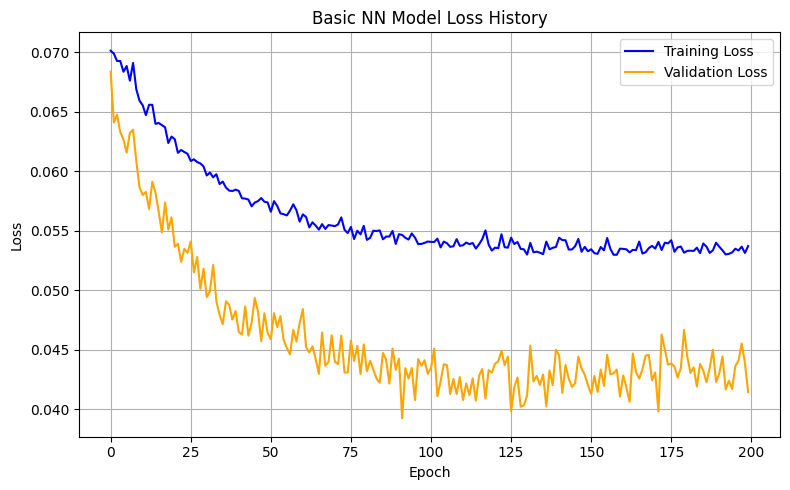

In [90]:
loss_history_plot = plot_loss(histories[0], title="Basic NN Model Loss History")

#### Baseline Model Visualizations

In [91]:
baseline_model_results = results["lin"]["basic"]

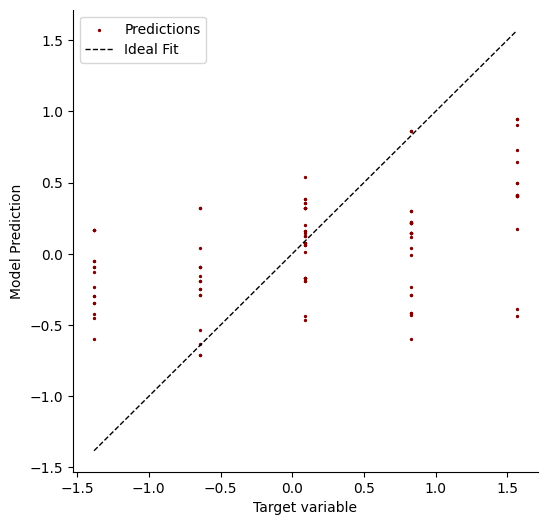

In [92]:
# Plot with non-rounded preds
baseline_plot = plot_predicted_vs_true(baseline_model_results.preds, y_test_arr)

#### Basic Random Forest Model Visualizations

In [94]:
basic_rf_model_results = results["rf"]["basic"]

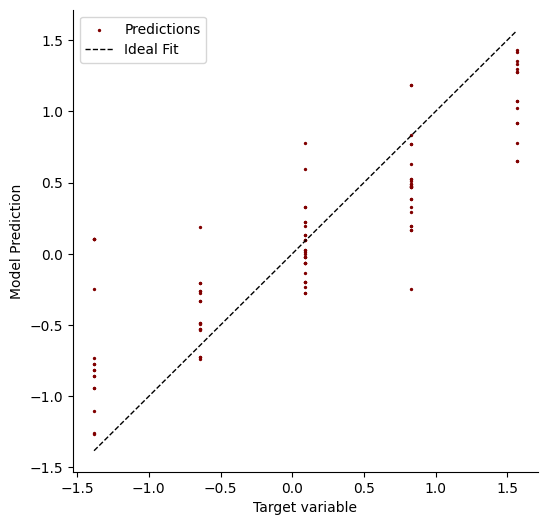

In [95]:
# Plot with non-rounded preds
rf_plot = plot_predicted_vs_true(basic_rf_model_results.preds, y_test_arr)

#### Basic Random Forest Model Visualizations

In [97]:
basic_nn_model_results = results["nn"]["basic"]

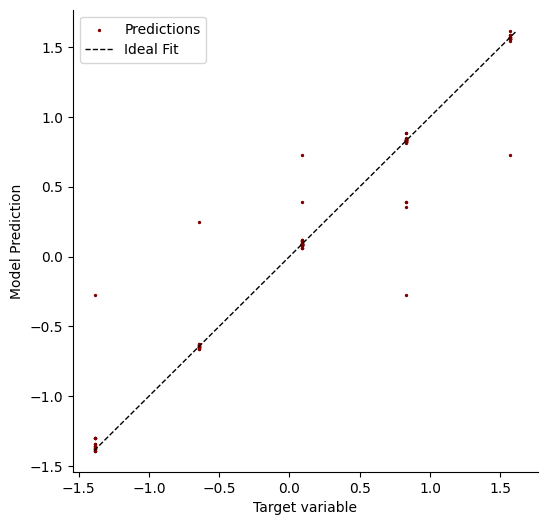

In [98]:
# Plot with non-rounded preds
nn_plot = plot_predicted_vs_true(basic_nn_model_results.preds, y_test_arr)

### Feature Importances

#### Shapley Values

In [60]:
# Create the explainer
explainer = shap.Explainer(basic_nn_model_results.model, basic_X_train) 

# Calculate SHAP values
shap_values = explainer(basic_X_test)  

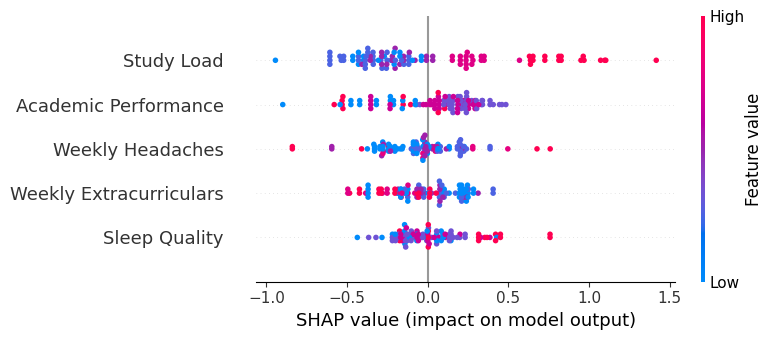

In [100]:

shap.summary_plot(shap_values, basic_X_test, feature_names=list(map(lambda x: x.replace("_", " "), X.columns.tolist()))[:k3_ind])

#### Feature Importances by Branching

In [40]:
importances = basic_rf_model_results.model.feature_importances_
feature_names = X.columns.tolist()

# Sort by importance
sorted_idx = np.argsort(importances)[::-1]

# Print top N features
for i in sorted_idx[:10]:  # top 10
    print(f"{feature_names[i]}: {importances[i]:.4f}")

Study_Load: 0.3114
Weekly_Extracurriculars: 0.1807
Academic_Performance: 0.1740
Weekly_Headaches: 0.1714
Sleep_Quality: 0.1625
